# 0. required packages for h5py

In [8]:
%run "..\Startup_py3.py"
sys.path.append(r"..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

AttributeError: type object '_yaml.Mark' has no attribute '__reduce_cython__'

# 1. Create field-of-view class

In [5]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH',
             'save_folder':r'I:\Pu_Temp\20200920_IgH_proB_DMSO_2color',
             #'save_folder':r'D:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             'experiment_type': 'DNA',
             'num_threads': 24,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201012-Corrections_2color',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3,23)

In [6]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=False
intensity_th = 200

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, 
                                                                   _binary_per_th=99.5, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.5,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile fr

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 2099.47s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_03.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_03.dax  in 15.211s
-- removing hot pixels for channels:['750'] in 24.842s
-- illumination correction for channels: 750, in 3.333s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 104.014s
-- finish correction in 159.288s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_03.hdf5
++ base attributes saved:['chrom_im'] in 15.36

E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 708 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 24 threads in 933.881s.
-- saving fov_info to file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_03.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.027s.
+ loading unique from file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_03.hdf5
++ finish loading unique in 0.063s. 
+ loading fov_info from file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_03.hdf5
++ base attributes loaded:[] in 1.989s.
- start select from 708 chromosomes with loss threshold=0.5
-- remove chr id 531, percentage of lost rounds:0.778.
-- remove chr id 234, percentage of lost rounds:0.722.
-- remove chr id 643, percentage of lost rounds:0.667.
-- remove chr id 271, percentage of lost rounds:0.660.
-- remove chr id 197, percentage of lost rounds:0.646.
-- remove chr id 529, percentage of lost rounds:0.639.
-- remove chr id 656, percentage of lost roun

-- No folder selected, allow processing all 73 folders
-- checking unique, region:[41 42] in 0.029s.
-- checking unique, region:[44 45] in 0.018s.
-- checking unique, region:[47 48] in 0.018s.
-- checking unique, region:[50 51] in 0.018s.
-- checking unique, region:[53 54] in 0.018s.
-- checking unique, region:[56 57] in 0.017s.
-- checking unique, region:[60 61] in 0.017s.
-- checking unique, region:[63 64] in 0.017s.
-- checking unique, region:[66 67] in 0.018s.
-- checking unique, region:[69 70] in 0.018s.
-- checking unique, region:[72 73] in 0.018s.
-- checking unique, region:[75 76] in 0.018s.
-- checking unique, region:[78 79] in 0.018s.
-- checking unique, region:[81 82] in 0.018s.
-- checking unique, region:[84 85] in 0.018s.
-- checking unique, region:[87 88] in 0.020s.
-- checking unique, region:[90 91] in 0.018s.
-- checking unique, region:[93 94] in 0.018s.
-- checking unique, region:[96 97] in 0.018s.
-- checking unique, region:[ 99 100] in 0.018s.
-- checking unique, reg

-- checking unique, region:[104  95] in 0.017s.
-- checking unique, region:[110 101] in 0.022s.
-- checking unique, region:[325 107] in 0.016s.
-- checking unique, region:[331 113] in 0.019s.
-- checking unique, region:[341 328] in 0.017s.
-- checking unique, region:[347 334] in 0.018s.
-- checking unique, region:[353 344] in 0.017s.
-- checking unique, region:[359 350] in 0.018s.
-- checking unique, region:[365 356] in 0.017s.
-- checking unique, region:[371 362] in 0.017s.
-- checking unique, region:[377 368] in 0.018s.
-- checking unique, region:[384 374] in 0.018s.
-- checking unique, region:[390 381] in 0.019s.
-- checking unique, region:[393 387] in 0.017s.
directly return existing attribute.
+ directly use current chromsome coordinates.
+ loading unique from file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_06.hdf5
++ finish loading unique in 0.089s. 
+ directly use current chromsome coordinates.
kept chromosomes: 644
Get Folder Names: (ia.get_img_info.get_folders)
- Num

-- checking unique, region:[81 82] in 0.018s.
-- checking unique, region:[84 85] in 0.018s.
-- checking unique, region:[87 88] in 0.018s.
-- checking unique, region:[90 91] in 0.018s.
-- checking unique, region:[93 94] in 0.018s.
-- checking unique, region:[96 97] in 0.018s.
-- checking unique, region:[ 99 100] in 0.018s.
-- checking unique, region:[102 103] in 0.018s.
-- checking unique, region:[105 106] in 0.018s.
-- checking unique, region:[108 109] in 0.018s.
-- checking unique, region:[111 112] in 0.018s.
-- checking unique, region:[114 115] in 0.019s.
-- checking unique, region:[323 321] in 0.018s.
-- checking unique, region:[326 324] in 0.018s.
-- checking unique, region:[329 327] in 0.018s.
-- checking unique, region:[332 330] in 0.018s.
-- checking unique, region:[335 333] in 0.019s.
-- checking unique, region:[339 337] in 0.018s.
-- checking unique, region:[342 340] in 0.018s.
-- checking unique, region:[345 343] in 0.018s.
-- checking unique, region:[348 346] in 0.018s.
-- c

kept chromosomes: 726
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 74
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
+ loading fov_info from file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_10.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 5.184s.
+ loading correction from file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_10.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2co

-- checking unique, region:[339 337] in 0.009s.
-- checking unique, region:[342 340] in 0.008s.
-- checking unique, region:[345 343] in 0.009s.
-- checking unique, region:[348 346] in 0.008s.
-- checking unique, region:[351 349] in 0.008s.
-- checking unique, region:[354 352] in 0.008s.
-- checking unique, region:[357 355] in 0.008s.
-- checking unique, region:[360 358] in 0.009s.
-- checking unique, region:[363 361] in 0.008s.
-- checking unique, region:[366 364] in 0.009s.
-- checking unique, region:[369 367] in 0.010s.
-- checking unique, region:[372 370] in 0.009s.
-- checking unique, region:[375 373] in 0.009s.
-- checking unique, region:[379 376] in 0.009s.
-- checking unique, region:[382 380] in 0.008s.
-- checking unique, region:[388 383] in 0.009s.
-- checking unique, region:[391 386] in 0.009s.
-- checking unique, region:[394 389] in 0.009s.
-- checking unique, region:[ 43 392] in 0.009s.
-- checking unique, region:[ 49 395] in 0.009s.
-- checking unique, region:[55 46] in 0.

++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5
++ base attributes loaded:[] in 0.009s.
-- saving fov_info to file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_13.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'ref_im', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', '

-- checking unique, region:[360 358] in 0.011s.
-- checking unique, region:[363 361] in 0.011s.
-- checking unique, region:[366 364] in 0.010s.
-- checking unique, region:[369 367] in 0.011s.
-- checking unique, region:[372 370] in 0.010s.
-- checking unique, region:[375 373] in 0.010s.
-- checking unique, region:[379 376] in 0.010s.
-- checking unique, region:[382 380] in 0.011s.
-- checking unique, region:[388 383] in 0.010s.
-- checking unique, region:[391 386] in 0.011s.
-- checking unique, region:[394 389] in 0.011s.
-- checking unique, region:[ 43 392] in 0.010s.
-- checking unique, region:[ 49 395] in 0.011s.
-- checking unique, region:[55 46] in 0.010s.
-- checking unique, region:[62 52] in 0.011s.
-- checking unique, region:[68 59] in 0.010s.
-- checking unique, region:[74 65] in 0.011s.
-- checking unique, region:[80 71] in 0.010s.
-- checking unique, region:[86 77] in 0.011s.
-- checking unique, region:[92 83] in 0.011s.
-- checking unique, region:[98 89] in 0.010s.
-- check

++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'cand_chrom_coords', 'channels', 'chrom_coords', 'chrom_im', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'ref_im', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 15.250s.
-- No folder selected, allow processing all 73 folders
-- checking unique, region:[41 42] in 0.015s.
-- checking unique, region:[44 45] in 0.012s.
-- checking unique, region:[47 48] in 0.013s.
-- checking unique, region:[50 51] in 0.012s.
-- checking unique, region:[53 54] in 0.013s.
-- checking unique, region:[56 57] in 0.012s.
-- checking unique, region:[60 61] in 0.012s.
-- checking unique, region:[63 64] in 0.012s.
-- checking unique, region:[6

-- checking unique, region:[74 65] in 0.012s.
-- checking unique, region:[80 71] in 0.012s.
-- checking unique, region:[86 77] in 0.011s.
-- checking unique, region:[92 83] in 0.012s.
-- checking unique, region:[98 89] in 0.013s.
-- checking unique, region:[104  95] in 0.012s.
-- checking unique, region:[110 101] in 0.012s.
-- checking unique, region:[325 107] in 0.012s.
-- checking unique, region:[331 113] in 0.012s.
-- checking unique, region:[341 328] in 0.012s.
-- checking unique, region:[347 334] in 0.012s.
-- checking unique, region:[353 344] in 0.012s.
-- checking unique, region:[359 350] in 0.012s.
-- checking unique, region:[365 356] in 0.012s.
-- checking unique, region:[371 362] in 0.013s.
-- checking unique, region:[377 368] in 0.012s.
-- checking unique, region:[384 374] in 0.013s.
-- checking unique, region:[390 381] in 0.013s.
-- checking unique, region:[393 387] in 0.012s.
directly return existing attribute.
+ directly use current chromsome coordinates.
+ loading unique

-- No folder selected, allow processing all 73 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_19.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_19.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_19.dax  in 13.284s
-- removing hot pixels for channels:['488'] in 13.089s
-- illumination correction for channels: 488, in 2.559s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 29.636s
-- saving fov_info to file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_19.hdf5
++ base attributes saved:['ref_im'] in 5.398s.
-- checking unique, region:[41 42] in 0.010s.
-- checking unique, region:[44 45] in 0.008s.
-- checking unique, region:[47 48] in 0.009s.
-- che

	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_20.dax: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5.
* create savefile: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5
-- saving fov_info to file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.020s.
-- saving segmentation to file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5
-- saving correction to file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_20.hdf5
-- sav

-- checking unique, region:[360 358] in 0.008s.
-- checking unique, region:[363 361] in 0.007s.
-- checking unique, region:[366 364] in 0.007s.
-- checking unique, region:[369 367] in 0.007s.
-- checking unique, region:[372 370] in 0.007s.
-- checking unique, region:[375 373] in 0.007s.
-- checking unique, region:[379 376] in 0.007s.
-- checking unique, region:[382 380] in 0.007s.
-- checking unique, region:[388 383] in 0.006s.
-- checking unique, region:[391 386] in 0.008s.
-- checking unique, region:[394 389] in 0.007s.
-- checking unique, region:[ 43 392] in 0.007s.
-- checking unique, region:[ 49 395] in 0.007s.
-- checking unique, region:[55 46] in 0.007s.
-- checking unique, region:[62 52] in 0.006s.
-- checking unique, region:[68 59] in 0.006s.
-- checking unique, region:[74 65] in 0.006s.
-- checking unique, region:[80 71] in 0.007s.
-- checking unique, region:[86 77] in 0.007s.
-- checking unique, region:[92 83] in 0.007s.
-- checking unique, region:[98 89] in 0.007s.
-- check

-- No folder selected, allow processing all 73 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_22.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_22.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200920-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_22.dax  in 14.746s
-- removing hot pixels for channels:['488'] in 12.169s
-- illumination correction for channels: 488, in 2.436s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 29.927s
-- saving fov_info to file: I:\Pu_Temp\20200920_IgH_proB_DMSO_2color\Conv_zscan_22.hdf5
++ base attributes saved:['ref_im'] in 5.665s.
-- checking unique, region:[41 42] in 0.009s.
-- checking unique, region:[44 45] in 0.008s.
-- checking unique, region:[47 48] in 0.008s.
-- che

In [20]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 5000nm
intensity_th = 500
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 24 threads, in 39.898s
-- collapse all regions into 1d.


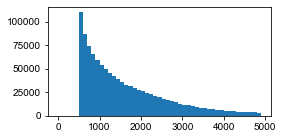

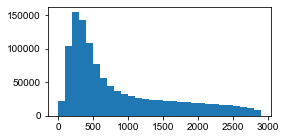

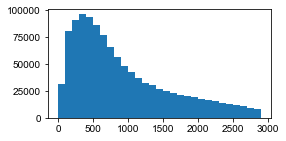

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 24 threads, in 43.196s


E:\Users\puzheng\Documents\ImageAnalysis3\spot_tools\picking.py:1995: RuntimeWarning: invalid value encountered in less
  return np.sum(diffs < 0.01) / np.sum(np.isnan(diffs)==False)


-- region kept: 0.9093
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 24 threads, in 39.698s
-- collapse all regions into 1d.


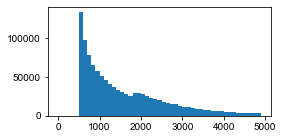

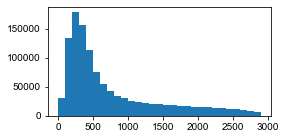

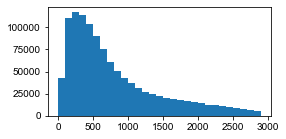

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 24 threads, in 45.448s
-- region kept: 0.9886
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 24 threads, in 40.795s
-- collapse all regions into 1d.


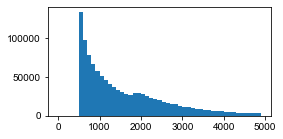

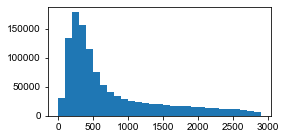

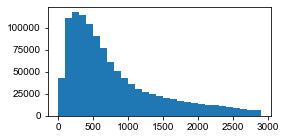

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 24 threads, in 46.016s
-- region kept: 0.9981


In [21]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 24
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


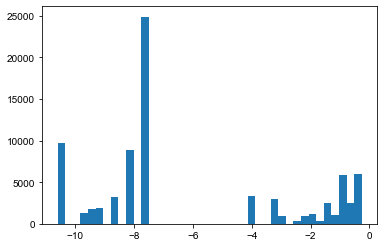

In [22]:
plt.figure()
plt.hist(np.log(np.ravel(sel_dna_scores_list[-1][:1000])), 40)
plt.show()

In [23]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = np.exp(-8)
int_th = 500
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _bad_inds = _kept_hzxys[:,0] < int_th
    _kept_hzxys[_bad_inds] = np.nan
    #_kept_hzxys[_scores < score_th] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


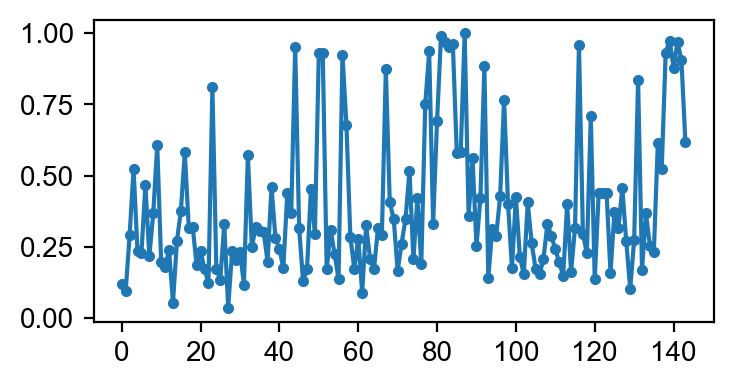

In [16]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,len(median_distmap),20))
plt.show()

In [17]:
kept_inds = np.where(loss_rates<0.5)[0]

In [1]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.axvline(x=74, color=[1,1,0])
ax.axhline(y=74, color=[1,1,0])
ax.set_title(f"proB DMSO, n={len(distmap_list)}", fontsize=7.5)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# generate full distmap
full_size = np.max(dna_reg_ids) - np.min(dna_reg_ids)+1

full_median_distmap = np.ones([full_size, full_size])*np.nan
full_median_distmap[np.arange(full_size), np.arange(full_size)] = np.zeros(len(full_median_distmap))
for _i, _id in enumerate(dna_reg_ids-np.min(dna_reg_ids)):
    full_median_distmap[_id, dna_reg_ids-np.min(dna_reg_ids)] = median_distmap[_i]
    

import matplotlib
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.4,0.4,0.4,1])

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(full_median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               cmap=median_cmap,
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0, np.max(dna_reg_ids)-np.min(dna_reg_ids), 50),
                                               tick_labels=np.arange(np.min(dna_reg_ids), np.max(dna_reg_ids),50), 
                                               figure_dpi=200)

ax.set_title(f"proB DMSO, n={len(distmap_list)}", fontsize=7.5)
ax.set_xlabel(f"5kb region ids", fontsize=7.5)
plt.show()

## visualize single example

In [ ]:
%matplotlib notebook
chrom_id = 3

import matplotlib
sc_cmap = matplotlib.cm.get_cmap('seismic_r')
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])


valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(distmap_list[chrom_id],
                                               #distmap_list[chrom_id][valid_inds][:,valid_inds], 
                                               cmap=sc_cmap,
                                               color_limits=[100,500],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"proB dox+ chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()



reload(figure_tools.image)
ax3d = figure_tools.image.chromosome_structure_3d_rendering(final_dna_hzxys_list[chrom_id][:,1:], 
                                                     #final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
                                                     marker_edge_line_width=0,
                                                     reference_bar_length=100, image_radius=200, 
                                                     line_width=0.5, figure_dpi=300, depthshade=True)
plt.show()

# Save

In [13]:
output_folder = r'\\10.245.74.158\Chromatin_NAS_6\20201031-processed_matrix'

np.save(os.path.join(output_folder, '20200920_proB_DMSO'), distmap_list)